In [2]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt

Preproccesing Functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 5
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.001 
    df[channel] = interpolated_values
    return df

def plot_eeg_data(before, after, title, colors):
    """Plots EEG data."""
    plt.figure(figsize=(12, 8))
    for i in range(before.shape[1]):
        plt.plot(before[:, i] + i * 200, color=colors[i])  # Offset added for visualization clarity
    for i in range(after.shape[1]):
        plt.plot(after[:, i] + i * 200, color=colors[i], linestyle='--')
    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


Define the dataset

In [12]:
# Creating a new folder for spike rejected data
new_folder = 'spike_rejected_data'
if not os.path.exists(new_folder):
    os.makedirs(new_folder)    
folder_name = 'ES_1'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

In [ ]:
subfolder_name = 'spike_rejected_data'
# Full path to the subfolder
spike_rejected_folder = os.path.join(folder_name, subfolder_name)
duration = 40 
EEG_Before_ICA = []
event = []
totaldata = []
face = []
scene = []
if os.path.exists(spike_rejected_folder) and os.path.isdir(spike_rejected_folder):
    for file_name in os.listdir(spike_rejected_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(spike_rejected_folder, file_name)
            s_temp = pd.read_csv(file_path, header=0)
            totaldata.append(s_temp)
            instruction = s_temp.iloc[:, 8]
            print(instruction.shape)
            baseline = s_temp[s_temp.iloc[:, -1].isin(['b', 'g'])].iloc[:, :-1]
            baseline_avg = baseline.mean()
            non_baseline_data = s_temp[~s_temp.iloc[:, -1].isin(['b', 'g'])]
            adjusted_non_baseline = non_baseline_data.iloc[:, :-1] - baseline_avg
            concatenated = pd.concat([baseline, adjusted_non_baseline], ignore_index=True)

            s_temp_baseline_rejected= pd.concat([concatenated, instruction], axis=1)
            print(s_temp_baseline_rejected.shape)
            
            # Check if the last column contains 'I' or 'O'
            if 'I' in instruction.values or 'O' in instruction.values:
                scene.append(s_temp_baseline_rejected)
            if 'M' in instruction.values or 'F' in instruction.values:
                face.append(s_temp_baseline_rejected)                
            df_temp = s_temp.iloc[:, :8]
            EEG_Before_ICA.append(df_temp)
            event.append(instruction)

In [172]:
face_np=np.array(face)
face_0_np= face_np[0].to_numpy()
face_0_np_reshape=face_0_np.reshape(face_0_np.shape[1], 250, int(face_0_np.shape[0]/250))
face_0_np_reshape.shape

C:\Users\Maryam\AppData\Local\Temp\ipykernel_55592\2445050080.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  face_np=np.array(face)


(9, 250, 46)

In [ ]:
for i in range (len(face_np)):
    face_i_np= face_np[i].to_numpy()
    face_i_np_reshape=face_i_np.reshape(face_i_np.shape[1], 250, int(face_i_np.shape[0]/250))
    print(face_i_np_reshape.shape)

In [175]:
face_0_np= face_np[0].to_numpy()
face_0_np_t=np.transpose(face_0_np)
face_0_np_reshape=face_0_np_t.reshape(face_0_np_t.shape[0], 250, int(face_0_np_t.shape[1]/250))


In [132]:
face_0_np_reshape.shape

(9, 250, 46)

In [107]:
# Calculate the sampling interval
sampling_interval = 1 / 250  
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000  

In [277]:
import numpy as np
import pandas as pd

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

# def convolve_with_wavelet(data, wavelet):
#     n_signal = data.shape[1]
#     n_wavelet = len(wavelet)
#     n_convolution = n_signal + n_wavelet - 1
#     data_fft = np.fft.fft(data, n_convolution, axis=1)
#     wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
#     convolution_result_fft = data_fft * wavelet_fft
#     convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
#     # Cut the data
#     start = (n_wavelet - 1) // 2
#     end = start + n_signal
#     return convolution_result[:, start:end]


def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]

    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

In [269]:
f_t=np.array(np.transpose(face_np[11]))
f_t_r=f_t
f_t.shape

(9, 10000)

In [330]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
power_matrix = []

for freq, cycle in zip(frequencies, cycles):
    power_blocks_base_corrected=[]
    for i in range (len(face_np)): #12
        # print('i=',i)
        face_i_np= face_np[i].to_numpy()
        face_i_np_t=np.transpose(face_i_np)
        # print(face_i_np_t.shape)
        # face_i_np_reshape=face_i_np_t.reshape(face_i_np_t.shape[0], 250*int(face_i_np_t.shape[1]/250))
        
        # Extract one channel
        data_i_face_t = face_i_np_t[0, :]  # Trials are on the second dimension
        # print(data_i_face.shape) #(250, 46)...(250,40)
        data_i_face_inst = face_i_np_t[8, :]
        # print('data_i_face_inst',data_i_face_inst.shape)
        # print(data_i_face_inst.shape) #(250, 46)...(250,40)
        # print(data_i_face_inst)
        # Calculate power for each trial
        # power_trials = []
        # instruction_label=[]

        wavelet = morlet_wavelet(freq, cycle, sampling_rate)
        convolution = convolve_with_wavelet(data_i_face_t , wavelet)    
        power = np.abs(convolution)**2
        # print('power',power.shape)
        
        # power_trial_np=np.array(power_trials)
            
        # print(power_trial_np.shape)
        # instruction_label.append(instruction_2D[0])
        # instruction_label_np=np.array(instruction_label)
        data_i_face_inst_2d = data_i_face_inst[np.newaxis, :]
        power_with_inst=np.concatenate([power,data_i_face_inst_2d], axis=0)
        # print('power_with_inst.shape', power_with_inst.shape)
        power_with_inst_t=np.transpose(power_with_inst)
        # print('power_with_inst_t.shape', type(power_with_inst_t), power_with_inst_t.shape)
        mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
        base = power_with_inst_t[mask]
        # mean_base= np.mean(base[:, :-1], axis=0)
        # print('mean_base', mean_base)
        
        epoch_size = 250
        epochs_base = []
        for start in range(0, len(base), epoch_size):
            end = start + epoch_size
            if end <= len(base):
                epochs_base.append(base[start:end])
            else:
                epochs_base.append(base[start:])
            epochs_base_np=np.array(epochs_base)
        # print(epochs_base_np.shape)
        
        # Calculate the mean across the first dimension, excluding the last column
        mean_epochs_base = np.mean(epochs_base_np[:, :, :-1], axis=0)

        first_200 = mean_epochs_base[:200]
        mean_base_200=np.mean(first_200, axis=0)
        
        # print('mean_base',mean_base_200)
        last_50 = mean_epochs_base[200:]
        # print('last_50', last_50)


        # 'mean_epochs' is now a 2D array with the means, excluding the label column
        # print("Shape of mean epochs_base (excluding labels):", mean_epochs_base.shape) 
        # mean=np.mean(mean_epochs_base, axis=0)
        # print('mean_base',mean)
        
        
        # print('base', base.shape, base)
        activity = power_with_inst_t[~mask]
        # print('activity ', activity.shape, activity )
        
        epoch_size = 250
        epochs = []
        for start in range(0, len(activity), epoch_size):
            end = start + epoch_size
            if end <= len(activity):
                epochs.append(activity[start:end])
            else:
                epochs.append(activity[start:])
            epochs_np=np.array(epochs)
        # print(epochs_np.shape)
        # Calculate the mean across the first dimension, excluding the last column
        activity_mean_epochs = np.mean(epochs_np[:, :, :-1], axis=0)
        activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
        baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
        # print('baseline_corrected_activity', baseline_corrected_activity.shape, baseline_corrected_activity)
        power_blocks_base_corrected.append(baseline_corrected_activity)
    power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
    # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape) 
    power_blocks_base_corrected_np_mean=np.mean(power_blocks_base_corrected_np,axis=0)
    # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean.shape)
    power_matrix.append(power_blocks_base_corrected_np_mean)
power_matrix_np=np.array(power_matrix)
print('power_matrix_np', power_matrix_np.shape)

power_matrix_np (20, 300, 1)


In [306]:
epochs_np.shape

(40, 250, 2)

In [ ]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
power_matrix = []

for freq, cycle in zip(frequencies, cycles):
    power_blocks=[]
    for i in range (len(face_np)): #12
        # print('i=',i)
        face_i_np= face_np[i].to_numpy()
        face_i_np_t=np.transpose(face_i_np)
        print(face_i_np_t.shape)
        # face_i_np_reshape=face_i_np_t.reshape(face_i_np_t.shape[0], 250*int(face_i_np_t.shape[1]/250))
        
        
        # Extract one channel
        data_i_face_t = face_i_np_t[0, :]  # Trials are on the second dimension
        # print(data_i_face.shape) #(250, 46)...(250,40)
        data_i_face_inst = face_i_np_t[8, :]
        # print(data_i_face_inst.shape) #(250, 46)...(250,40)
        print(data_i_face_inst)
        # Calculate power for each trial
        power_trials = []
        instruction_label=[]
        for trial_idx in range(data_i_face.shape[1]):
            trial_2D = data_i_face[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            instruction_2D = data_i_face_inst[:, trial_idx]
            # print(instruction_2D)
            
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            
            power = np.abs(convolution)**2
            
            power_trials.append(power[0])
            power_trial_np=np.array(power_trials)
            
            # print(power_trial_np.shape)
            instruction_label.append(instruction_2D[0])
            instruction_label_np=np.array(instruction_label)
            # power_trial_np_with_inst=np.concatenate([power_trial_np,instruction_label_np], axis=0)
      
            
        # power_trial_np_with_inst=np.concatenate([power_trial_np,instruction_label_np], axis=0 )
        # print(power_trial_np_with_inst.shape)
        # power_baseline = power_trial_np[s_temp.iloc[:, -1].isin(['b', 'g'])].iloc[:, :-1]
        # baseline_avg = baseline.mean()
        # non_baseline_data = s_temp[~s_temp.iloc[:, -1].isin(['b', 'g'])]
        # adjusted_non_baseline = non_baseline_data.iloc[:, :-1] - baseline_avg
        # concatenated = pd.concat([baseline, adjusted_non_baseline], ignore_index=True)

        # s_temp_baseline_rejected= pd.concat([concatenated, instruction], axis=1)
        # print(s_temp_baseline_rejected.shape)        
        power_blocks.append(power_trials)
        
        
        # print(len(power_blocks))
        # mean_power_block=np.mean(power_blocks, axis=0)
        # print(mean_power_block.shape)
        # print('power_blocks', len(power_blocks))
    # Average power across trials
    avg_power = np.mean(power_blocks, axis=0)
    power_matrix.append(avg_power)
    # print('power_tmatrix', len(power_matrix))
    power_matrix_np= np.array(power_matrix)

In [250]:
data_i_face_inst[:, 39]

array(['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F

In [ ]:
# Baseline correction function
def baseline_correction(power_matrix, power_matrix_baseline):
    return power_matrix/power_matrix_baseline  # Division for baseline correction

# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 3 to 10
sampling_rate=250

# Calculate power for variable and fixed cycles
power_variable_cycles = calculate_power(cycles)
power_baseline_variable_cycles = calculate_power_baseline(cycles)

power_fixed_cycles = calculate_power([4] * len(frequencies))  # Fixed cycle: 4
power_baseline_fixed_cycles = calculate_power_baseline([4] * len(frequencies))  # Fixed cycle: 4

# Apply baseline correction
corrected_variable = baseline_correction(power_variable_cycles,power_baseline_variable_cycles )
corrected_fixed = baseline_correction(power_fixed_cycles, power_baseline_fixed_cycles)


In [187]:
power_matrix_np.shape

(20, 527, 250)

In [198]:
power_matrix_np.shape[0]

20

In [199]:
instruction_label_np=np.array(instruction_label)
instruction_label_np_reshape=instruction_label_np.reshape(int(power_matrix_np.shape[0]), int(instruction_label_np.shape[0]/power_matrix_np.shape[0]), 250)

In [200]:
instruction_label_np_reshape.shape

(20, 527, 250)

In [ ]:



# Baseline correction function
def baseline_correction(power_matrix, power_matrix_baseline):
    return power_matrix/power_matrix_baseline  # Division for baseline correction

# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 3 to 10
sampling_rate=250

# Calculate power for variable and fixed cycles
power_variable_cycles = calculate_power(cycles)
power_baseline_variable_cycles = calculate_power_baseline(cycles)

power_fixed_cycles = calculate_power([4] * len(frequencies))  # Fixed cycle: 4
power_baseline_fixed_cycles = calculate_power_baseline([4] * len(frequencies))  # Fixed cycle: 4

# Apply baseline correction
corrected_variable = baseline_correction(power_variable_cycles,power_baseline_variable_cycles )
corrected_fixed = baseline_correction(power_fixed_cycles, power_baseline_fixed_cycles)



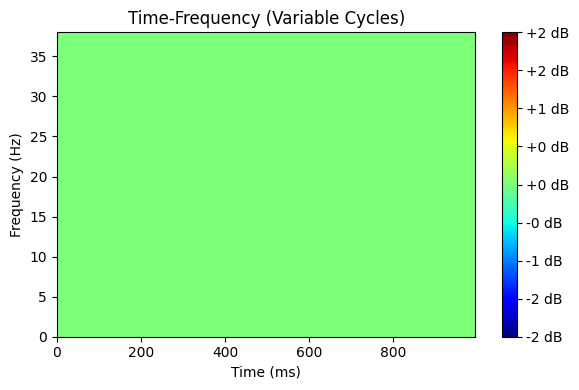

In [113]:
# Plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(100* np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[0], times[249], frequencies[0], frequencies[-1]],
               vmin=-2, vmax=2)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()
# Plot the results
plot_time_frequency(corrected_variable_scene , 'Time-Frequency (Variable Cycles)')
